In [19]:
import os,sys,glob,fitsio,subprocess
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.table import Table, Column
import desimodel.io
import desimodel.footprint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setting output path for this notebook

In [2]:
# Folder where multipass will execute
multipass_name='mini_multipass'
# Change this path if you want to
outdir= os.path.join(os.environ['SCRATCH'],'tucson2020_hacks/fiberassign',multipass_name)
os.makedirs(outdir, exist_ok=True)
print('Working on {}'.format(outdir))

Working on /global/cscratch1/sd/forero/tucson2020_hacks/fiberassign/mini_multipass


# Selecting the Year 1 footprint from surveysims

First we read the exposure.fits file from surveysims path

In [3]:
sim_path = "/project/projectdirs/desi/datachallenge/surveysim2018/weather/035/"
exposures = Table.read(os.path.join(sim_path,'exposures.fits'), hdu=1)
exposures[:5]

MJD,EXPTIME,TILEID,SNR2FRAC,AIRMASS,SEEING,TRANSP,SKY
float64,float32,int32,float32,float32,float32,float32,float32
58819.063888888886,920.0,28576,0.5002821,1.0944833,1.01959,0.9735375,1.0
58819.07523148129,660.0,28576,1.00477,1.0944833,0.9895672,0.9818349,1.0
58819.08425925893,1080.0,28589,0.50211537,1.093335,1.1533324,0.96132696,1.0
58819.09745370316,650.0,28589,1.0113196,1.093335,0.87564546,0.9578879,1.0
58819.10636574006,610.0,28588,0.5042863,1.096941,0.77289426,0.9925911,1.0


Find which tiles are covered during first year

In [31]:
cadence=365
w=np.where(np.int_((exposures['MJD']-exposures['MJD'].min())/cadence)==0)

In [32]:
year1=exposures[w]
year1[:5]

MJD,EXPTIME,TILEID,SNR2FRAC,AIRMASS,SEEING,TRANSP,SKY
float64,float32,int32,float32,float32,float32,float32,float32
58819.063888888886,920.0,28576,0.5002821,1.0944833,1.01959,0.9735375,1.0
58819.07523148129,660.0,28576,1.00477,1.0944833,0.9895672,0.9818349,1.0
58819.08425925893,1080.0,28589,0.50211537,1.093335,1.1533324,0.96132696,1.0
58819.09745370316,650.0,28589,1.0113196,1.093335,0.87564546,0.9578879,1.0
58819.10636574006,610.0,28588,0.5042863,1.096941,0.77289426,0.9925911,1.0


For this test we will use a small area (100 sq.deg), so first we will get those tiles in a 100 sq.deg

In [33]:
alltiles = Table(desimodel.io.load_tiles())
not_bright = alltiles['PROGRAM']!='BRIGHT' # We are only insterested in GREY|DARK targets
tiles= alltiles[not_bright]
# If you want to run whole footprint comment these lines
#ii = (120 < tiles['RA']) & (tiles['RA']<160) & (0<tiles['DEC']) & (tiles['DEC']<40)
#tiles=tiles[ii]
print('There are {} tiles in this area.'.format(len(tiles)))

There are 9990 tiles in this area.


Now lets see which of those tiles are covered on the first year and save the exposures.fits file for this area. This is needed to run multipass

In [34]:
w=np.isin(tiles['TILEID'],year1['TILEID'])
tiles=tiles[w]
print('There are {} year 1 tiles in this area.'.format(len(tiles)))

There are 2607 year 1 tiles in this area.


In [35]:
expfolder=os.path.join(outdir,'exposures')
os.makedirs(expfolder,exist_ok=True)
expfile=os.path.join(expfolder,'exposuresY1.fits')
if os.path.exists(expfile):
    print('exposures file already done; skipping')
    year1=Table(fitsio.read(expfile))
else:
    print('Writing exposure file in {}'.format(expfile))
    w=np.isin(year1['TILEID'],tiles['TILEID'])
    year1=year1[w]
    year1.write(expfile)

Writing exposure file in /global/cscratch1/sd/forero/tucson2020_hacks/fiberassign/mini_multipass/exposures/exposuresY1.fits


In [36]:
year1 = Table.read(expfile)
tiles = Table(desimodel.io.load_tiles())
unique_tileid = list(set(year1['TILEID']))
ii = np.in1d(tiles['TILEID'], unique_tileid)
tiles_year1 = tiles[ii]

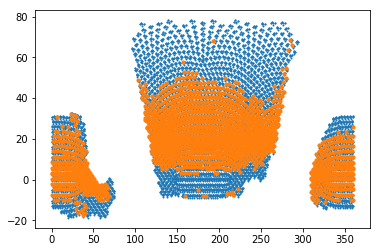

In [43]:
plt.scatter(tiles['RA'], tiles['DEC'], s=1.0, label='full footprint')
plt.scatter(tiles_year1['RA'], tiles_year1['DEC'], s=10.0, label='first year')

# Reducing a whole footprint mock target selection run to match our footprint

In this step we will select the targets that match the Y1 footprint from a whole footprint mock target selection catalog, these can be found in 
```
/global/projecta/projectdirs/desi/users/alxogm/desi/select_mock_targets/onlyqso_all_sky_nospec
```

this is a run of `select_mock_targets` run of only qsos and stars.

Thanks to Alma for this run!

In [9]:
def reducefile(file,tiles,outdir='./',nside=16):
    tilepixels=desimodel.footprint.tiles2pix(nside=nside, tiles=tiles)
    print('Getting {} footprint pixels from {}'.format(tilepixels.size,file))
    pixels=Table(fitsio.read(file,columns=['HPXPIXEL']))
    whichtargets=np.isin(pixels['HPXPIXEL'],tilepixels)
    rows=np.where(whichtargets==True)[0]
    filename=os.path.split(file)[-1]
    print('Reducing data')
    reduced = Table(fitsio.read(file,rows=rows))
    name=os.path.join(outdir,filename)
    print(f'Writing reduced file {name}')
    reduced.write(name,overwrite=True)
    print('DONE')
    del reduced
    return rows

In [10]:
mockpath='/global/projecta/projectdirs/desi/users/alxogm/desi/select_mock_targets/onlyqso_all_sky_nospec/'
truthfile=os.path.join(mockpath,'truth-dark.fits')
mtlfile=os.path.join(mockpath,'mtl-dark.fits')
skyfile=os.path.join(mockpath,'sky.fits')

In [11]:
do_reducefiles = False
for filename in ['truth-dark.fits','mtl-dark.fits','sky.fits']:
    if not os.path.exists(os.path.join(outdir,filename)):
        do_reducefiles = True
        break
if do_reducefiles==False:
    print('Already reduced files; skipping')
else:
    print('Reducing files, this should take ~10 minutes')
    sky = reducefile(skyfile,tiles,outdir)
    rows = reducefile(mtlfile,tiles,outdir)
    reduced_truth = Table(fitsio.read(truthfile,rows=rows)) # Truth file doesn't contain a TARGETID column but its aranged the same way as mtl
    reduced_truth.write(os.path.join(outdir,'truth-dark.fits'),overwrite=True)
    del reduced_truth

Already reduced files; skipping


# Run multipass

For this part you will need to clone my repository of multipass from github: 
```
git clone https://github.com/HiramHerrera/multipass.git
```

this is a modified version from Jaime Forero's multipass (can be found in https://github.com/forero/multipass). 

Much thanks to Jaime for this script!

In [12]:
# Change this to the path to your own copy of multipass
path_to_multipass='/global/homes/h/hiramk/multipass' 

In [13]:
# Multipass inputs
cadence=180 # Days after each fiberassign is done
mtlfile=os.path.join(outdir,"mtl-dark.fits")
truthfile=os.path.join(outdir,"truth-dark.fits")
skyfile=os.path.join(outdir,"sky.fits")
expfile=os.path.join(outdir,"exposures/exposuresY1.fits")
zcat=os.path.join(outdir,"zcatY1.fits")

In [14]:
if os.path.exists(zcat):
    print('Multipass already done; skipping.')
else:
    print('Running multipass, should take ~1 hour.')
    logfilename=os.path.join(outdir,'multipass.log')
    cmd = 'srun -A desi -N 1 -C knl -t 02:00:00 --qos interactive '
    cmd+= 'python {}/run_multilayer.py --mtl {} --truth {} --sky {} '.format(path_to_multipass,mtlfile,truthfile,skyfile)
    cmd+= '--expfile {} --cadence {} --zcat {} --outdir {}/ '.format(expfile,cadence,zcat,outdir)
    print('Starting at {}'.format(time.asctime()))
    print(cmd)
    print('Logging to {}'.format(logfilename))
    
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('\nERROR {} running multipass; see {}'.format(err, logfilename))
        else:
            print('done')

Multipass already done; skipping.


# Analize multipass outputs

Create some useful functions

In [15]:
def create_density_file(cat,outfile=None,nside=16,nest=True):
    maxnumobs=max(cat['NUMOBS'])
    pixels = hp.ang2pix(nside, np.pi/2.-cat['DEC']*np.pi/180.,cat['RA']*np.pi/180.,nest=nest)
    pixarea = hp.pixelfunc.nside2pixarea(nside, degrees=True)
    unique_pixels = np.unique(pixels)
    
    # GENERATE TABLE AND TABLE META
    colnames = ['HPXPIXEL','LOWZ_DENS','MIDZ_DENS','HIGHZ_DENS']
    tbl = Table(names=colnames,dtype=('i8','f8','f8','f8'))
    tbl.meta['name'] = 'DESI YEAR 1 QSOS FOOTPRINT'
    tbl.meta['comments'] =['This table contains information about the QSO density for each pixel']
    tbl.meta['NSIDE'] = nside
    tbl.meta['NEST'] = nest
    
    # REDSHIFT MASKS
    lowz = cat['TRUEZ']<1.8
    midz = (cat['TRUEZ']>=1.8)&(cat['TRUEZ']<2.1)
    highz= cat['TRUEZ']>=2.1

    
    bins = np.arange(1,2+maxnumobs)
    prob_numobs=np.zeros((unique_pixels.size,maxnumobs))
    for i,pix in enumerate(unique_pixels):
        lowz_dens = np.count_nonzero(pixels[lowz]==pix)/pixarea
        midz_dens = np.count_nonzero(pixels[midz]==pix)/pixarea
        highz_dens= np.count_nonzero(pixels[highz]==pix)/pixarea
        
        prob_numobs[i]=np.histogram(cat['NUMOBS'][highz][pixels[highz]==pix],density=True,bins=bins)[0]
        tbl.add_row((pix,lowz_dens,midz_dens,highz_dens))
    tbl.add_column(Column(prob_numobs,name='PROB_NUMOBS'))  

    if outfile:
        tbl.write(outfile,overwrite=True)
        print(f'Saved {outfile} file')
        return
    else:
        return tbl
    
def scatterdens(pix,dens,nside=16,nest=True,clabel='Density'):
    theta,phi = hp.pix2ang(nside,pix,nest=nest)
    dec,ra = (np.pi/2-theta)*180/np.pi,phi*180/np.pi
    scat=plt.scatter(ra,dec,c=dens)
    plt.xlabel("RA")
    plt.ylabel("DEC")
    cbar = plt.colorbar(scat)
    cbar.set_label(clabel)
    
def generateplots(ifile):
    zcat = Table(fitsio.read(ifile))
    zcat = zcat[zcat['NUMOBS']!=0]
    qsos=zcat[zcat['TRUESPECTYPE']=='QSO']
    data = create_density_file(qsos)
    print('Generating density plots for {} pixels'.format(len(data)))
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.title('LOW Z')
    scatterdens(data['HPXPIXEL'],data['LOWZ_DENS'])
    
    plt.subplot(1,3,2)
    plt.title('MID Z')
    scatterdens(data['HPXPIXEL'],data['MIDZ_DENS'])

    plt.subplot(1,3,3)
    plt.title('HIGH Z')
    scatterdens(data['HPXPIXEL'],data['HIGHZ_DENS'])
    plt.figure(figsize=(12,10))
    for i in range(data['PROB_NUMOBS'].shape[1]):
        plt.subplot(2,2,i+1)
        plt.title(f'NUMOBS {i+1}')
        scatterdens(data['HPXPIXEL'],data['PROB_NUMOBS'][:,i],clabel='PROBABILITY')

This will generate a quasar density plot for year one run

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Generating density plots for 105 pixels


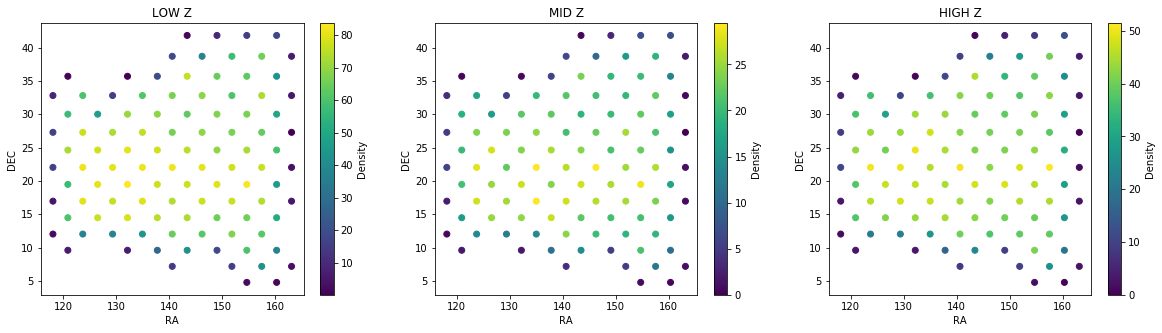

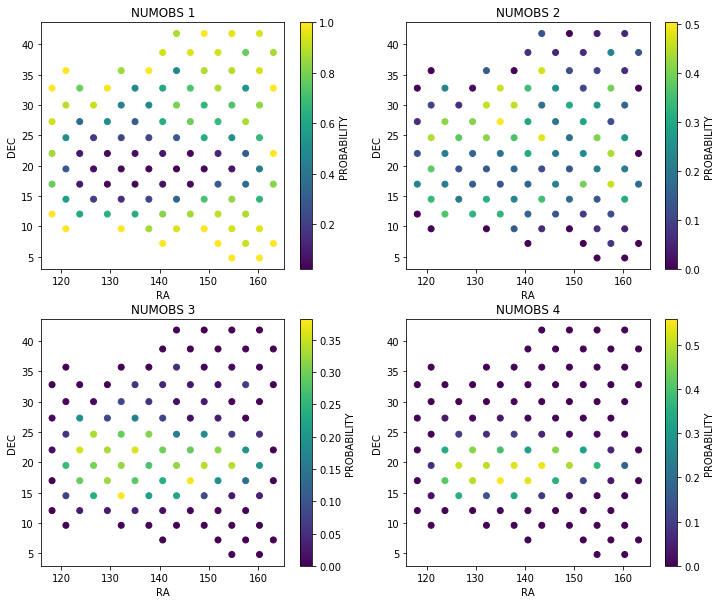

In [16]:
idir = outdir
ifile=idir+'/zcatY1.fits'
generateplots(ifile)

This generates a density file, to be used by `quickquasars`

In [17]:
zcat = Table(fitsio.read(ifile))
zcat = zcat[zcat['NUMOBS']!=0]
qsos=zcat[zcat['TRUESPECTYPE']=='QSO']
data = create_density_file(qsos) # If output keyword is on this function it creates a fits file

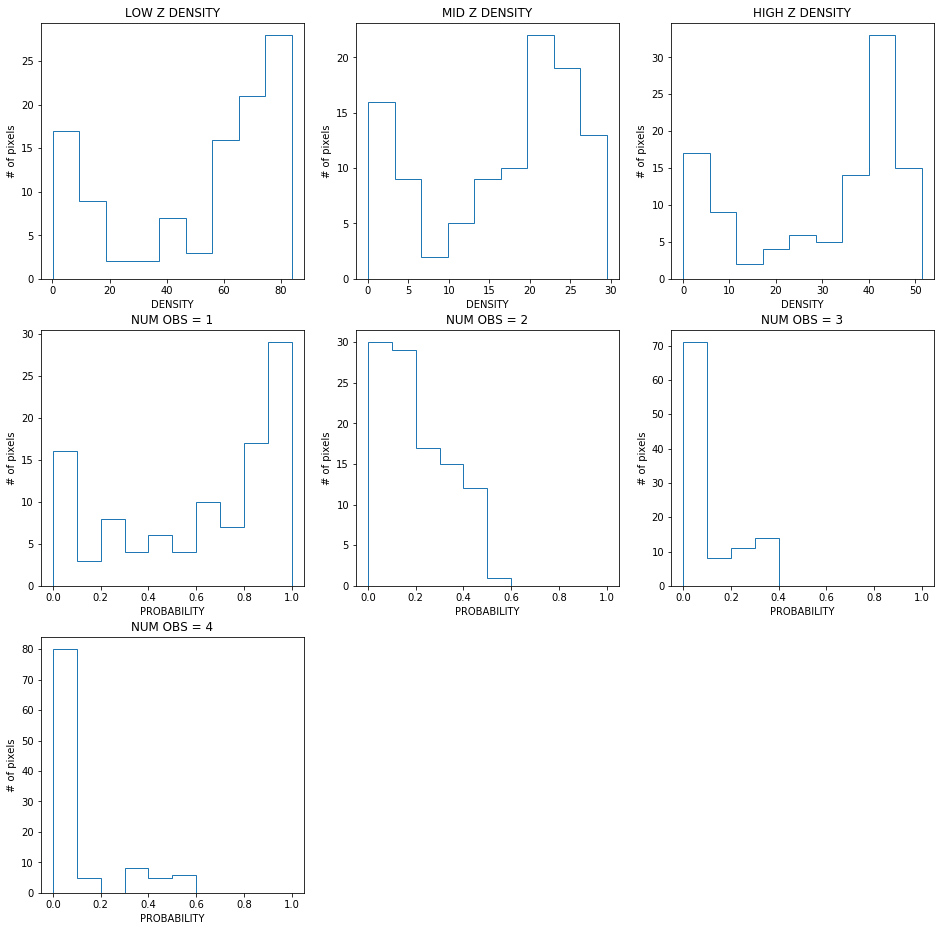

In [18]:
plt.figure(figsize=(16,16))
titles=['LOW Z DENSITY','MID Z DENSITY','HIGH Z DENSITY','NUM OBS = 1','NUM OBS = 2','NUM OBS = 3','NUM OBS = 4']
attribs = ['LOWZ_DENS','MIDZ_DENS','HIGHZ_DENS','PROB_NUMOBS']
j=0
for a in attribs:
    if a!='PROB_NUMOBS':
        plt.subplot(3,3,j+1)
        plt.title(titles[j])
        bins = np.linspace(min(data[a]),max(data[a]),10)
        plt.hist(data[a],histtype='step',bins=bins,lw=1)
        plt.xlabel('DENSITY')
        plt.ylabel('# of pixels')
        j+=1
    else:
        for i in range(data['PROB_NUMOBS'].shape[1]):
            bins=np.arange(0,1.1,.1)
            plt.subplot(3,3,j+1)
            plt.title(titles[j])
            plt.hist(data[a][:,i],histtype='step',bins=bins,lw=1)
            plt.xlabel('PROBABILITY')
            plt.ylabel('# of pixels')
            j+=1

## Redshift distribution

Text(0,0.5,'# of qsos')

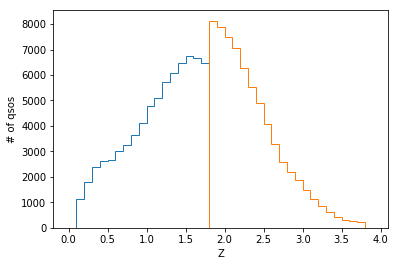

In [19]:
plt.hist(qsos['TRUEZ'][qsos['TRUEZ']<1.8],histtype='step',bins=np.arange(0,4,0.1),label='QSO')
plt.hist(qsos['TRUEZ'][qsos['TRUEZ']>=1.8],histtype='step',bins=np.arange(0,4,0.1),label='LYA')
plt.xlabel('Z')
plt.ylabel('# of qsos')

# Fiber assign QA

Something broken with QA

In [22]:
targetdir=outdir
fibassigndir=os.path.join(targetdir,'cadence_{}/fiberassign_full'.format(cadence))

In [23]:
!qa-fiberassign --verbose --targets $targetdir/mtl-dark.fits $fibassigndir/fiberassign-*.fits

Traceback (most recent call last):
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/fiberassign/master/bin/qa-fiberassign", line 89, in <module>
    sciencemask, stdmask, skymask, safemask, excludemask = default_survey_target_masks(survey)
ValueError: too many values to unpack (expected 5)
